In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [2]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/
/gdrive


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd My Drive
%cd Colab Notebooks

/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'ahmetfurkandemr/mask-datasets-v1'
!mkdir Dataset
! unzip -q mask-datasets-v1.zip -d Dataset

Saving kaggle.json to kaggle.json
 98% 737M/754M [00:07<00:00, 91.9MB/s]
100% 754M/754M [00:08<00:00, 98.5MB/s]


### **Define the Data Directory**

In [4]:
base_dir = './Dataset/Mask_Datasets'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training Mask/No Mask pictures
train_mask_dir = os.path.join(train_dir, 'Mask')
train_nomask_dir = os.path.join(train_dir, 'No_mask')

# Directory with our validation cat/dog pictures
valid_mask_dir = os.path.join(validation_dir, 'Mask')
valid_nomask_dir = os.path.join(validation_dir, 'No_mask')

In [5]:
print('total training Mask images :', len(os.listdir(train_mask_dir ) ))
print('total training No Mask images :', len(os.listdir(train_nomask_dir ) ))

print('total validation Mask images :', len(os.listdir( valid_mask_dir ) ))
print('total validation No Mask images :', len(os.listdir( valid_nomask_dir ) ))

total training Mask images : 350
total training No Mask images : 400
total validation Mask images : 150
total validation No Mask images : 200


## **Shuffling Image Dataset**

In [20]:
import random
from shutil import copy

def absoluteFilePaths(directory):
  filelist = []
  for dirpath,_,filenames in os.walk(directory):
    for f in filenames:
      filelist.append(os.path.abspath(os.path.join(dirpath, f)))
  return filelist

mask_img = absoluteFilePaths(train_mask_dir) + absoluteFilePaths(valid_mask_dir)
nomask_img = absoluteFilePaths(train_nomask_dir) + absoluteFilePaths(valid_nomask_dir)

random.shuffle(mask_img)
random.shuffle(nomask_img)

!mkdir -p Shuffled_Mask_Datasets/Train/Mask Shuffled_Mask_Datasets/Train/No_mask \
Shuffled_Mask_Datasets/Validation/Mask Shuffled_Mask_Datasets/Validation/No_mask

new_train_dir = os.path.join('./Shuffled_Mask_Datasets/Train')
new_valid_dir = os.path.join('./Shuffled_Mask_Datasets/Validation')
new_train_mask_dir = os.path.join('./Shuffled_Mask_Datasets/Train/Mask')
new_train_nomask_dir = os.path.join('./Shuffled_Mask_Datasets/Train/No_mask')
new_valid_mask_dir = os.path.join('./Shuffled_Mask_Datasets/Validation/Mask')
new_valid_nomask_dir = os.path.join('./Shuffled_Mask_Datasets/Validation/No_mask')

for i in range(0,len(mask_img)):
  if i<len(os.listdir(train_mask_dir)):
    copy(mask_img[i], new_train_mask_dir+'/'+str(i)+'.'+mask_img[i].split('.')[1])
  else:
    copy(mask_img[i], new_valid_mask_dir+'/'+str(i)+'.'+mask_img[i].split('.')[1])

for i in range(0,len(nomask_img)):
  if i<len(os.listdir(train_nomask_dir)):
    copy(nomask_img[i], new_train_nomask_dir+'/'+str(i)+'.'+nomask_img[i].split('.')[1])
  else:
    copy(nomask_img[i], new_valid_nomask_dir+'/'+str(i)+'.'+nomask_img[i].split('.')[1])

print('total training mask images:', len(os.listdir(new_train_mask_dir)))
print('total training no mask images:', len(os.listdir(new_train_nomask_dir)))
print('total validation mask images:', len(os.listdir(new_valid_mask_dir)))
print('total validation no mask images:', len(os.listdir(new_valid_nomask_dir)))
print('--')
print('total training images:', len(os.listdir(new_train_mask_dir))
                      + len(os.listdir(new_train_nomask_dir)))
print('total validation images:', len(os.listdir(new_valid_mask_dir))
                      + len(os.listdir(new_valid_nomask_dir)))
print('total images:', len(os.listdir(new_train_mask_dir))
                      + len(os.listdir(new_train_nomask_dir))
                      + len(os.listdir(new_valid_mask_dir))
                      + len(os.listdir(new_valid_nomask_dir)))

total training mask images: 350
total training no mask images: 646
total validation mask images: 150
total validation no mask images: 285
--
total training images: 996
total validation images: 435
total images: 1431


In [21]:
import tensorflow as tf
import numpy as np
import pathlib

new_train_dir = pathlib.Path(new_train_dir)
new_valid_dir = pathlib.Path(new_valid_dir)
CLASS_NAMES = np.array([item.name for item in new_train_dir.glob('*')])
list_train_ds = tf.data.Dataset.list_files(str(new_train_dir/'*/*'))
list_valid_ds = tf.data.Dataset.list_files(str(new_valid_dir/'*/*'))

## Image Visualization

In [22]:
# Now, let's see what the filenames look like in the Mask and no mask train directories 
# (file naming conventions are the same in the validation directory)

train_mask_fnames = os.listdir( new_train_mask_dir )
train_nomask_fnames = os.listdir( new_train_nomask_dir )

print(train_mask_fnames[:10])
print(train_nomask_fnames[:10])

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images


['1.PNG', '0.PNG', '2.PNG', '4.PNG', '3.PNG', '9.PNG', '7.PNG', '6.PNG', '10.PNG', '5.PNG']
['4.4', '12.jpg', '20.jpg', '27.9', '40.jpg', '65.jpg', '106.jpg', '113.jpg', '124.jpg', '139.jpg']


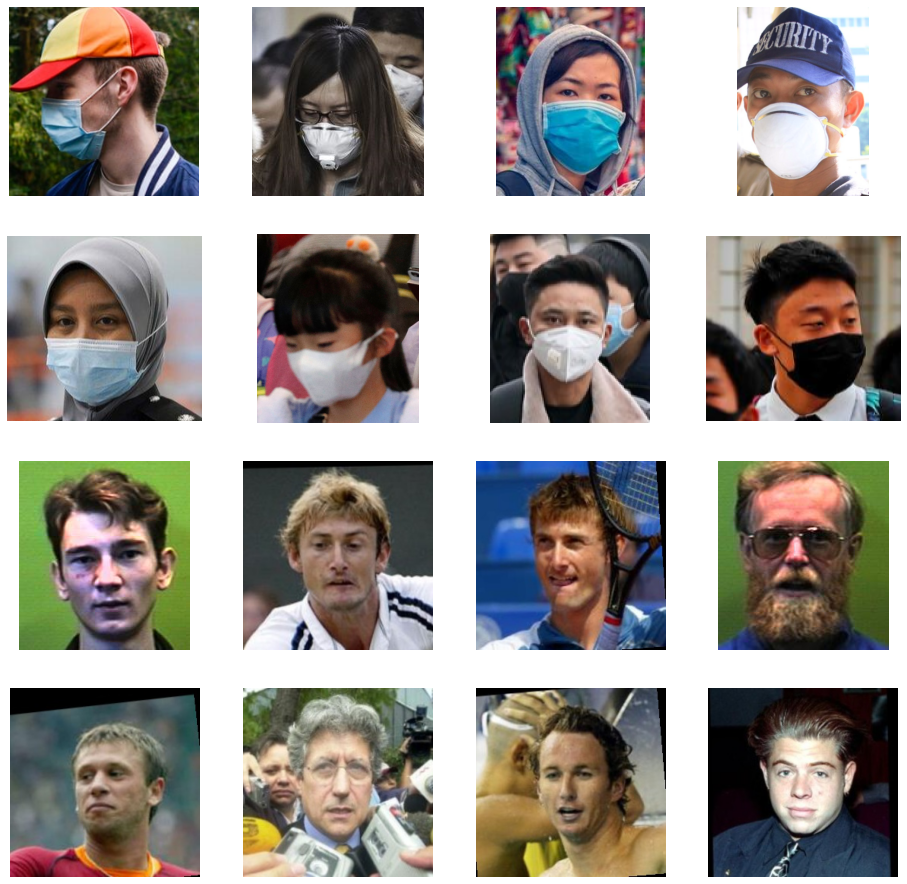

In [23]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_mask_pix = [os.path.join(new_train_mask_dir, fname) 
                for fname in train_mask_fnames[ pic_index-8:pic_index] 
               ]

next_nomax_pix = [os.path.join(new_train_nomask_dir, fname) 
                for fname in train_nomask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_mask_pix+next_nomax_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## **CNN Model using Mobilenet**

In [219]:
# USE THIS MODEL INSTEAD

IMAGE_SIZE = 224
dense = 2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False

In [232]:
# ADD SOME LAYERS ABOVE BASE LAYER MODEL
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
   tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

print('Base model ready')

Base model ready


In [233]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7, 1280)        0         
_________________________________________________________________
dense_54 (Dense)             (None, 7, 7, 1024)        1311744   
_________________________________________________________________
dropout_26 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
dense_55 (Dense)             (None, 7, 7, 512)         524800    
_________________________________________________________________
global_average_pooling2d_27  (None, 512)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 2)               

In [222]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

# The ImageGenerator rescaling, rotate and do other operations.
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        new_train_dir,  # This is the source directory for training images
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to IMAGE_SIZE
        batch_size=20,
        class_mode='categorical')

Found 964 images belonging to 2 classes.


### **Image Augmentation using ImageDataGenerator**

In [223]:
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        new_valid_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=20,
        class_mode='categorical')

history = model.fit(
      train_generator,
      epochs=15,
      validation_data= validation_generator,
      verbose=1)

Found 428 images belonging to 2 classes.
Epoch 1/15
49/49 [==============================] - 41s 845ms/step - loss: 0.4794 - accuracy: 0.8361 - val_loss: 0.3297 - val_accuracy: 0.9953
Epoch 2/15
49/49 [==============================] - 40s 824ms/step - loss: 0.3506 - accuracy: 0.9720 - val_loss: 0.3200 - val_accuracy: 0.9977
Epoch 3/15
49/49 [==============================] - 41s 838ms/step - loss: 0.3339 - accuracy: 0.9865 - val_loss: 0.3153 - val_accuracy: 1.0000
Epoch 4/15
49/49 [==============================] - 41s 845ms/step - loss: 0.3273 - accuracy: 0.9865 - val_loss: 0.3227 - val_accuracy: 0.9953
Epoch 5/15
49/49 [==============================] - 41s 834ms/step - loss: 0.3276 - accuracy: 0.9865 - val_loss: 0.3141 - val_accuracy: 1.0000
Epoch 6/15
49/49 [==============================] - 41s 840ms/step - loss: 0.3261 - accuracy: 0.9865 - val_loss: 0.3135 - val_accuracy: 1.0000
Epoch 7/15
49/49 [==============================] - 41s 832ms/step - loss: 0.3237 - accuracy: 0.9886 

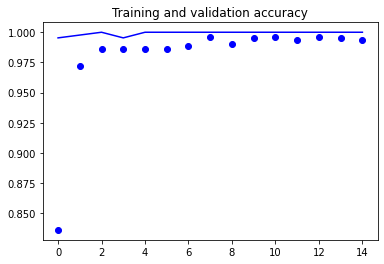

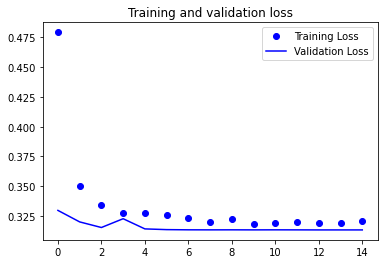

In [224]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [205]:
base_model.trainable = True

In [206]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [207]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])

In [225]:
#@title Import Photos From Google Drive
from keras.preprocessing import image
import numpy as np

countF=0
countT=0

for fn in os.listdir('./teset'):
 
  # predicting images
  path='./teset/' + fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=20)
  if classes[0][0]>classes[0][1]:
      print(fn + " is wearing a mask")
      countT+=1
  else:
      print(fn + " is not wearing a mask")
      countF+=1
  



mask0.png is wearing a mask
mask1.png is not wearing a mask
nomask12.png is wearing a mask
mask5.png is wearing a mask
nomask8.png is not wearing a mask
nomask13.png is not wearing a mask
maskside0.png is wearing a mask
mask7.png is wearing a mask
mask8.png is wearing a mask
mask3.png is not wearing a mask
mask4.png is not wearing a mask
mask6.png is not wearing a mask
masknyan.png is wearing a mask
maskside1.png is not wearing a mask
nomask1.png is not wearing a mask
nomask2.png is wearing a mask
nomask4.png is wearing a mask
nomask5.png is not wearing a mask
nomask6.png is not wearing a mask
nomask7.png is not wearing a mask
nomask9.png is not wearing a mask
unnamed.png is wearing a mask


In [228]:
from google.colab import files
files.download('/content/model.zip')

In [229]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)